## MLP -- BatchNorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [133]:
block_size = 3 # context length: how many chars do we take to predict the next one

# build dataset
def build_dataset(words):
    
    X, Y = [], []
    for w in words:
#         print(w)

        context = [0]* block_size
        for ch in w+'.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [134]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])  #80%
X_eval, Y_eval = build_dataset(words[n1:n2])  #10%
X_test, Y_test = build_dataset(words[n2:])    #10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [135]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator = g) # 2 dimentional embedding
#Hidden Layer 
l1_n = 300
W1 = torch.randn((block_size*n_emb, n_hidden), generator = g) * (5/3)/(block_size*n_emb)**0.5 # Kaiming init
#b1 = torch.randn(n_hidden, generator = g) * 0.01  #this is useless when using Batch Norm
# Second/Final layer
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01   # should not set weights as all 0, but a small number
b2 = torch.randn(vocab_size, generator = g)*0     #biases can be 0 at the beginning

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [136]:
batch_size = 32
steps = 200000
lossi = []


In [137]:
for i in range(steps):

    
    idx = torch.randint(0, X_train.shape[0], (batch_size,), generator = g)
    
    #Forward Pass
    emb = C[X_train[idx]]  
    embcat = emb.view(emb.shape[0],-1)
    #Linear Layer
    hpreact = embcat  @ W1 #+ b1
#     print(b1.grad)

    #BatchNorm Layer
    bnmean_i =  hpreact.mean(0, keepdim=True)
    bnstd_i = hpreact.std(0, keepdim=True)
    # Batch Normalization Layer, samples in the batch mathmatically coupled (not favored), 
    # effective for deeper neural networks, but still there are other options including LayerNorm
    hpreact = bngain * (hpreact - bnmean_i)/bnstd_i + bnbias 
    
    
    # Non-linearity
    h = torch.tanh(hpreact) 
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Y_train[idx])

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmean_i    #approximation, 0.001 is momentum (0.1 as default in pytorch BN)
        bnstd_running = 0.999*bnstd_running + 0.001*bnstd_i
    
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 10**-2 if i > 100000 else 10**-1
    for p in parameters:
        p.data += -lr * p.grad
        
#     break
#     stepi.append(i)
    lossi.append(loss.log10().item())
    

print(loss.item())

2.302304744720459


## On BatchNorm
<span style="font-size:16px">It is published in 2015, first normalization that helps to stablize the statistics of the activation for training much deeper NN. Its downside is mathmatically coupling the batch. Alternatives includ GroupNorm, LayerNorm</span>

In [110]:
bnmean_running

tensor([[ 1.6224e+00,  9.5406e-02,  1.5774e+00,  6.9493e-01,  9.0569e-01,
         -3.4030e-01,  2.0018e+00,  4.0917e-01,  4.9469e-01,  1.2234e+00,
         -2.2609e-01, -6.6479e-01,  2.6409e-01,  2.2386e-01, -1.6987e+00,
         -1.6421e-01, -1.3654e+00, -4.6757e-01, -9.9255e-01, -6.1464e-01,
         -6.4345e-01, -7.6946e-02, -1.5010e+00,  5.8743e-01, -3.8703e+00,
         -5.8563e-01,  1.3614e+00,  1.3055e-01, -1.4291e+00, -1.8276e+00,
          2.2134e+00, -9.8660e-02, -3.4213e+00, -2.1330e-01,  3.3965e-01,
         -2.7587e+00, -9.4083e-01, -6.4694e-01,  5.3479e-01,  7.8328e-01,
          1.4413e+00, -5.2064e-01, -4.4549e-01,  2.4488e+00, -1.9197e+00,
         -4.8450e-01,  5.0009e-01, -1.2704e-03,  2.3377e+00,  1.4246e+00,
         -3.1000e-01,  9.2799e-01, -2.0813e+00, -2.7864e+00, -5.0855e-01,
          5.9470e-01,  1.0863e+00,  1.0974e+00,  9.6478e-01,  3.8066e-01,
         -1.0016e+00,  3.3910e-01, -1.5829e+00, -4.8998e-01, -3.8130e-01,
          1.5158e+00,  1.5537e+00,  7.

In [111]:
bnstd_running

tensor([[1.4266, 2.1229, 1.3580, 1.4281, 2.0102, 1.6903, 1.5095, 1.2384, 1.6193,
         1.4158, 2.2240, 1.1525, 1.4959, 1.5931, 1.4249, 1.2097, 1.6884, 1.6872,
         1.7600, 1.7335, 1.8211, 1.5268, 1.3460, 1.8788, 1.4711, 1.6744, 1.5570,
         1.4583, 1.6782, 1.7383, 1.4629, 1.8051, 1.6441, 1.5496, 1.5830, 1.5516,
         1.3694, 1.7881, 1.7460, 1.8301, 1.5357, 1.7514, 1.4922, 1.5932, 1.5489,
         1.7858, 1.8428, 1.4829, 1.6165, 1.6448, 1.3901, 1.8117, 1.4714, 1.6761,
         1.7092, 1.6651, 1.2410, 1.5693, 1.5459, 1.5393, 1.4062, 1.5172, 1.8296,
         1.6284, 1.5143, 1.5448, 1.2664, 1.1169, 1.7885, 1.5485, 1.3545, 1.8062,
         1.7258, 1.6365, 1.5774, 1.3030, 1.2687, 1.5091, 1.4827, 2.0938, 1.7340,
         1.2845, 1.7390, 1.6348, 1.5913, 1.8922, 1.4277, 1.6694, 1.6458, 1.4176,
         1.3499, 1.5925, 1.4348, 1.5442, 1.5360, 1.6526, 1.5034, 1.7593, 1.3836,
         1.4740, 1.6264, 1.7584, 1.7003, 1.4230, 1.4647, 1.7142, 1.6661, 1.5580,
         1.7167, 1.7877, 1.7

In [108]:
with torch.no_grad():
    emb = C[X_train[idx]]  
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat  @ W1 + b1
    
    bnmean =  hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [109]:
bnmean

tensor([[ 1.8090,  0.2808,  1.2424,  0.4718,  0.9137, -0.3021,  2.0225,  0.4674,
          0.6399,  1.0210,  0.0707, -0.7444,  0.2658,  0.1899, -1.6120, -0.3079,
         -1.3065, -0.6370, -0.7649, -0.4355, -0.7895,  0.0536, -1.2759,  0.5667,
         -3.7929, -0.2555,  1.1702,  0.2269, -1.5187, -2.0288,  2.2869,  0.1924,
         -3.3703, -0.0499,  0.3031, -2.6606, -0.9106, -0.8820,  0.4269,  1.0587,
          1.2592, -0.6310, -0.1915,  2.5108, -1.8795, -0.4983,  0.5209,  0.0720,
          2.3439,  1.7036, -0.4413,  0.7639, -2.1847, -2.9560, -0.7239,  0.8038,
          0.8023,  0.9846,  0.8408,  0.2405, -1.1367,  0.4663, -1.6614, -0.4283,
         -0.5097,  1.5273,  1.6977,  0.5909,  0.4238,  2.5865,  2.2703,  1.9775,
          0.4839, -1.6221,  2.3880,  0.7225, -0.6014,  2.5013,  3.3869, -0.4746,
          1.0959, -0.3959,  1.2515,  1.0698, -0.6481,  0.6310,  1.2051, -0.4629,
          1.8487,  1.1989,  0.1639,  1.0042, -0.8921, -0.5799,  1.9499, -1.3445,
         -0.4977,  1.0851, -

In [112]:
bnstd

tensor([[1.2316, 2.0298, 1.2305, 1.3836, 2.0282, 1.9566, 1.4601, 1.3997, 1.6153,
         1.4385, 2.2654, 1.1446, 1.4471, 1.6664, 1.4591, 1.1441, 1.8406, 1.5323,
         1.7617, 1.6323, 1.7954, 1.7675, 1.3613, 2.0210, 1.4486, 1.5520, 1.6734,
         1.4928, 1.5154, 1.8987, 1.1379, 1.9045, 1.6252, 1.4505, 1.7752, 1.4934,
         1.6386, 1.3963, 1.5813, 1.7802, 1.5386, 1.5786, 1.3017, 1.5544, 1.5786,
         1.6989, 1.6880, 1.8771, 1.4568, 1.7796, 1.4204, 1.9944, 1.6979, 1.7860,
         1.4973, 1.6805, 1.2679, 1.2207, 1.6872, 1.2181, 1.4459, 1.5452, 2.0691,
         1.5414, 1.5123, 1.7182, 1.0794, 1.2936, 1.8080, 1.8413, 1.6548, 2.1214,
         1.5355, 1.3848, 1.5373, 1.3408, 1.0306, 1.7851, 1.3062, 2.1182, 1.6970,
         1.2682, 1.7973, 1.7138, 1.3592, 1.7690, 1.5370, 1.6334, 1.3116, 1.4394,
         1.6105, 1.3364, 1.4855, 1.3600, 1.4169, 1.3540, 1.6744, 1.6500, 1.2698,
         1.4064, 1.7923, 1.6073, 1.6719, 1.6341, 1.7657, 1.6909, 1.5531, 1.3930,
         1.7796, 1.3442, 1.6

In [86]:
hpreact.shape

torch.Size([32, 200])

In [85]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [87]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

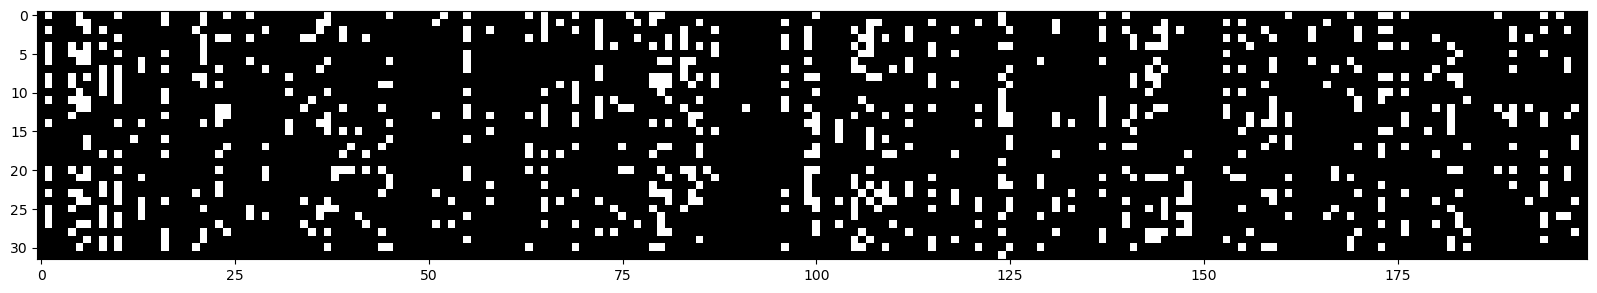

In [66]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation='nearest')

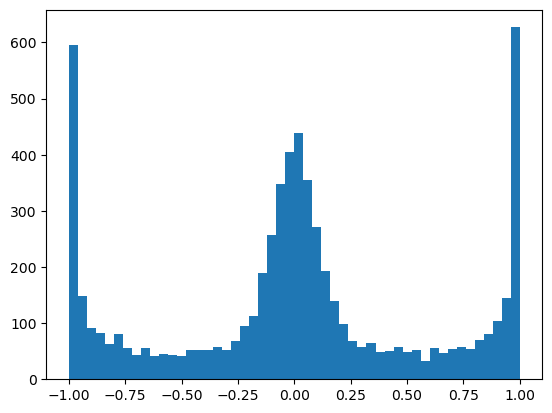

In [67]:
plt.hist(h.view(-1).tolist(), 50);

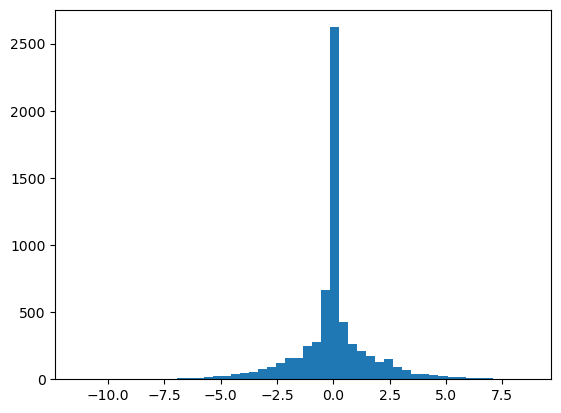

In [68]:
plt.hist(hpreact.view(-1).tolist(), 50);

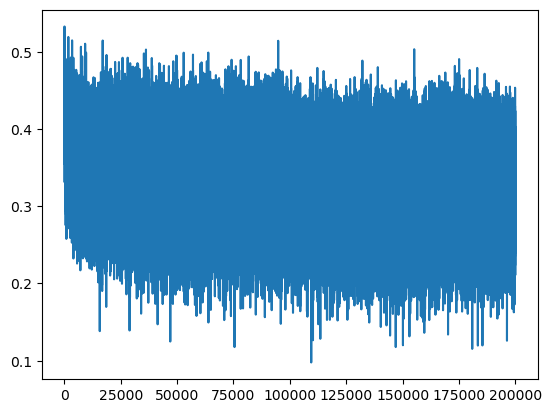

In [130]:
plt.plot(lossi)

In [131]:
@torch.no_grad()  #this decorator disables gradient tracking (required_grad = False)

def split_loss(split):
    x,y = {
        'train':(X_train, Y_train),
        'val': (X_eval, Y_eval),
        'test': (X_test, Y_test),
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat  @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.067413330078125
val 2.105684995651245


In [132]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    out = []
    context = [0] *block_size
    while True:
        emb = C[torch.tensor([context])]
#         print(C.shape)
        h = torch.tanh( emb.view(1,-1) @ W1 + b1) 
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [idx]
        out.append(itos[idx])

        if idx == 0:
            break
    print(''.join(out))

briahgmnazzierstel.
fyll.
qetvangendra.
zasderidgmlillshi.
pelleksissandvannellyssllyaphn.
shdumrithghnestin.
jewtdvi.
xibuscfsubferndersymusemels.
kaylahshmyah.
haz.
sadya.
sufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabubulysskhmregynishaidfflystlwaldarikthrishthzighikassmitgftrvissivishten.
riefhrriyaxabushdumichekitya.
blvardtai.
bdgihzirrlq.
saadenaysophlrystta.
ziyah.
vontet.


## Restart Everything

### Initialization needs to be improved
Uniformed distribution for each char

In [26]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

## Batch Normalization

#### Enables to train very deep NN

# Part2 Train a deeper NN

In [452]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) /fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None  #this can be set to False when using Batch Norm
        
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        

In [430]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True   #
        
        self.gamma = torch.ones(dim)   #gain
        self.beta = torch.zeros(dim)  #bias
        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum*xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [431]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [447]:
dim_emb = 10
dim_hidden = 100
g= torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, dim_emb),  generator = g)   #embedding

C.shape

torch.Size([27, 10])

In [448]:
layers = [
    Linear(dim_emb *block_size, dim_hidden), BatchNorm1d(dim_hidden), Tanh(),
    Linear(dim_hidden, dim_hidden), BatchNorm1d(dim_hidden), Tanh(),
    Linear(dim_hidden, dim_hidden), BatchNorm1d(dim_hidden), Tanh(),
    Linear(dim_hidden, dim_hidden), BatchNorm1d(dim_hidden), Tanh(),
    Linear(dim_hidden, dim_hidden), BatchNorm1d(dim_hidden), Tanh(),
    Linear(dim_hidden, vocab_size), BatchNorm1d(vocab_size),
]

# layers = [
#     Linear(dim_emb *block_size, dim_hidden), Tanh(),
#     Linear(dim_hidden, dim_hidden), Tanh(),
#     Linear(dim_hidden, dim_hidden), Tanh(),
#     Linear(dim_hidden, dim_hidden), Tanh(),
#     Linear(dim_hidden, dim_hidden), Tanh(),
#     Linear(dim_hidden, vocab_size),
# ]


with torch.no_grad():
    layers[-1].gamma *=0.1
#     layers[-1].weight *=0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [449]:
batch_size = 32
max_steps = 200000
lossi = []
ud = []

In [450]:
for i in range(max_steps):

    # Construct Minibatch
    idx = torch.randint(0, X_train.shape[0], (batch_size,), generator = g)
    Xb,Yb = X_train[idx], Y_train[idx]
    
    #Forward Pass
    emb = C[Xb]  
    x = emb.view(emb.shape[0],-1)
    
    for layer in layers:
        x = layer(x)
        
    loss = F.cross_entropy(x, Yb)

    
    #backward
    for layer in layers:
        layer.out.retain_grad()  #AFTER DEBUG: would take out retain _grad
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 10**-2 if i > 100000 else 10**-1
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        # lr * p.grad is the update that will be applied
        ud.append([(lr * p.grad.std()/ p.data.std()).log10().item() for p in parameters])
    if i > 1000:
        break
print(loss.item())

      0/ 200000: 3.3313
2.382978677749634


layer 2 (      Tanh) : mean -0.01, std 0.63, saturated: 2.69%
layer 5 (      Tanh) : mean -0.00, std 0.64, saturated: 2.12%
layer 8 (      Tanh) : mean -0.00, std 0.64, saturated: 2.00%
layer 11 (      Tanh) : mean -0.00, std 0.64, saturated: 2.00%
layer 14 (      Tanh) : mean -0.00, std 0.64, saturated: 2.06%


Text(0.5, 1.0, 'Activation distribution(Initialization weight * 5/3)')

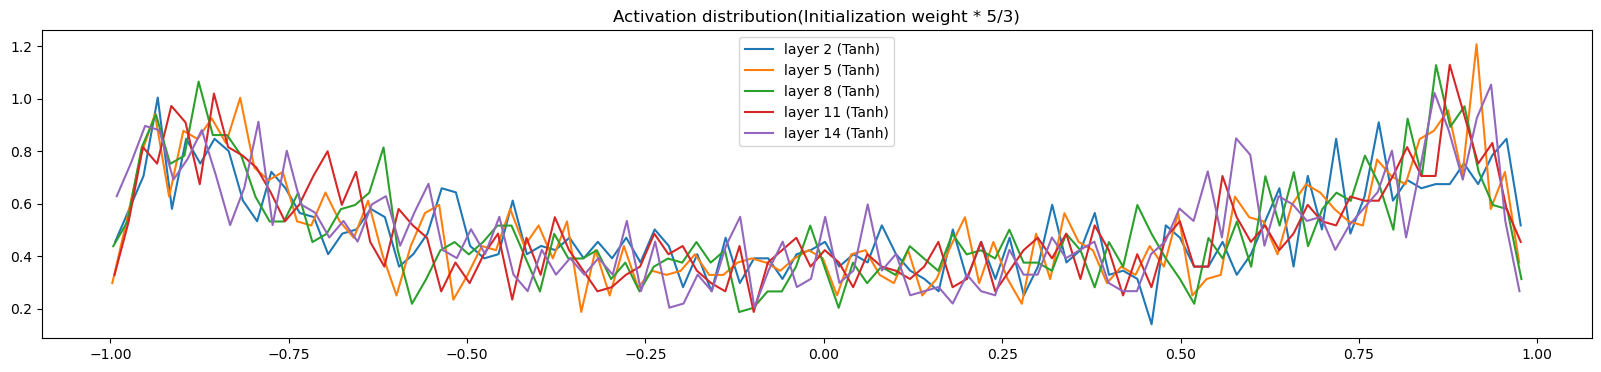

In [451]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # Width and height of the plot
    
    if isinstance(layer, Tanh):   # Range [-1, 1], exclude the output layer
        t = layer.out
        print('layer %d (%10s) : mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution(Initialization weight * 5/3)')
# plt.savefig('Init_1.6.png', dpi=300, bbox_inches='tight')

## Diagrams with different gain (without BatchNorm)

#### Init weight * 1
<span style="font-size:16px">When gain is small (less than 5/3), the first layer is great, yet the following layers' shape start to shrink and ```std``` gets close to 0. Since Tanh layers are squashing function, they take in the distribution and slightly squash it. Gain can help fight the squashing. So when gain sets to be 1, it cannot fight the squashing enough, thus the distribution shrinks. </span>



<span style="font-size:16px">layer 1 (      Tanh) : mean +0.01, std 0.63, saturated: 3.75%  
layer 3 (      Tanh) : mean -0.03, std 0.48, saturated: 0.09%  
layer 5 (      Tanh) : mean +0.01, std 0.39, saturated: 0.00%  
layer 7 (      Tanh) : mean -0.01, std 0.34, saturated: 0.00%  
layer 9 (      Tanh) : mean +0.02, std 0.31, saturated: 0.00%  </span>

![Alt text](./init_1.1.png)

#### Init weight * 5/3



<span style="font-size:16px">layer 1 (      Tanh) : mean -0.05, std 0.77, saturated: 22.25%   
layer 3 (      Tanh) : mean +0.00, std 0.69, saturated: 10.50%   
layer 5 (      Tanh) : mean +0.02, std 0.67, saturated: 7.25%   
layer 7 (      Tanh) : mean -0.01, std 0.65, saturated: 5.06%   
layer 9 (      Tanh) : mean -0.01, std 0.65, saturated: 6.38%</span>

![Alt text](./init_1.6.1.png)



### Init weight * 4
<span style="font-size:16px"> When gain is large, ```std``` gets close to 1, too saturated</span>


<span style="font-size:16px"> layer 1 (      Tanh) : mean -0.06, std 0.90, saturated: 61.94%   
layer 3 (      Tanh) : mean +0.01, std 0.89, saturated: 56.22%   
layer 5 (      Tanh) : mean +0.04, std 0.89, saturated: 57.59%   
layer 7 (      Tanh) : mean +0.01, std 0.88, saturated: 56.31%   
layer 9 (      Tanh) : mean -0.02, std 0.88, saturated: 53.94%</span>

![Alt text](./init_4.png)

layer 2 (      Tanh) : mean +0.000000, std 3.344251e-03
layer 5 (      Tanh) : mean -0.000000, std 2.725498e-03
layer 8 (      Tanh) : mean -0.000000, std 2.472116e-03
layer 11 (      Tanh) : mean -0.000000, std 2.045029e-03
layer 14 (      Tanh) : mean -0.000000, std 1.829584e-03


Text(0.5, 1.0, 'Gradient distribution(Initialization weight * 5/3)')

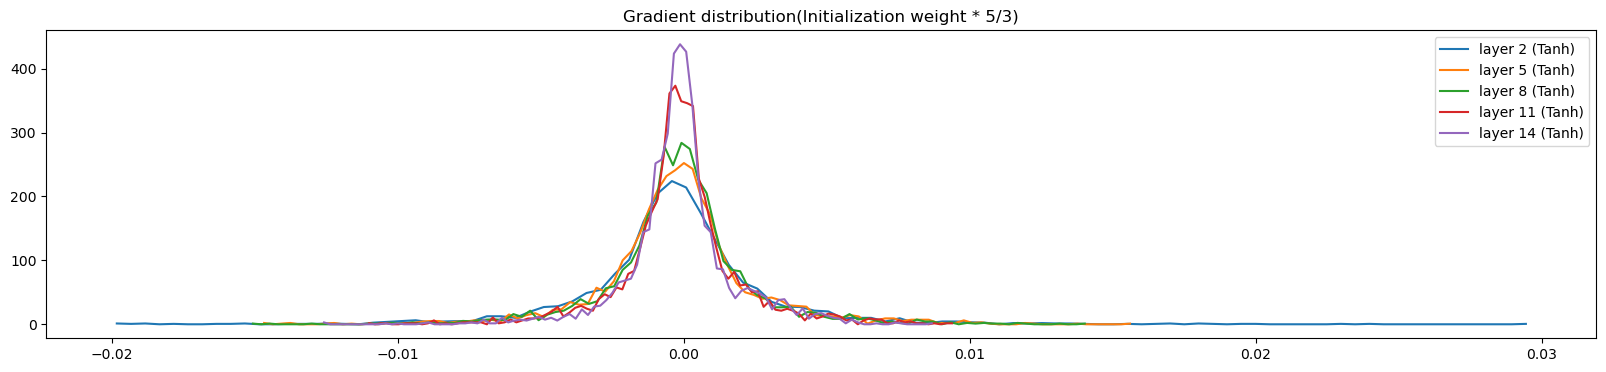

In [426]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s) : mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution(Initialization weight * 5/3)')
# plt.savefig('Grad_0.5.png', dpi=300, bbox_inches='tight')

### Init weight * 1

<span style="font-size:16px">layer 1 (      Tanh) : mean -0.000004, std 1.729259e-04   
layer 3 (      Tanh) : mean -0.000002, std 2.195117e-04   
layer 5 (      Tanh) : mean +0.000008, std 2.547761e-04   
layer 7 (      Tanh) : mean +0.000006, std 2.788735e-04   
layer 9 (      Tanh) : mean -0.000007, std 3.028657e-04</span>

![Alt text](./Grad_1.png)

### Init weight * 5/3

<span style="font-size:16px"> layer 1 (      Tanh) : mean -0.000008, std 4.314909e-04   
layer 3 (      Tanh) : mean -0.000005, std 4.109006e-04   
layer 5 (      Tanh) : mean +0.000013, std 3.769949e-04   
layer 7 (      Tanh) : mean +0.000010, std 3.360866e-04   
layer 9 (      Tanh) : mean -0.000007, std 3.030647e-04</span>

![Alt text](./Grad_1.6.png)

### Init weight * 4

<span style="font-size:16px"> layer 1 (      Tanh) : mean -0.000015, std 1.857272e-03   
layer 3 (      Tanh) : mean -0.000026, std 1.209060e-03   
layer 5 (      Tanh) : mean +0.000027, std 7.949463e-04   
layer 7 (      Tanh) : mean +0.000018, std 4.865238e-04   
layer 9 (      Tanh) : mean -0.000007, std 3.033830e-04 </span>

![Alt text](./Grad_4.png)

weight   (27, 10) | mean -0.000000 | std 9.812568e-03 | grad:data ratio 9.802677e-03
weight  (30, 100) | mean +0.000234 | std 8.235495e-03 | grad:data ratio 2.635231e-02
weight (100, 100) | mean +0.000104 | std 7.290129e-03 | grad:data ratio 4.362399e-02
weight (100, 100) | mean -0.000046 | std 6.696874e-03 | grad:data ratio 3.972192e-02
weight (100, 100) | mean +0.000037 | std 6.521096e-03 | grad:data ratio 3.886164e-02
weight (100, 100) | mean -0.000034 | std 5.906421e-03 | grad:data ratio 3.518368e-02
weight  (100, 27) | mean -0.000082 | std 1.058378e-02 | grad:data ratio 6.353919e-02


Text(0.5, 1.0, 'weights gradient distribution')

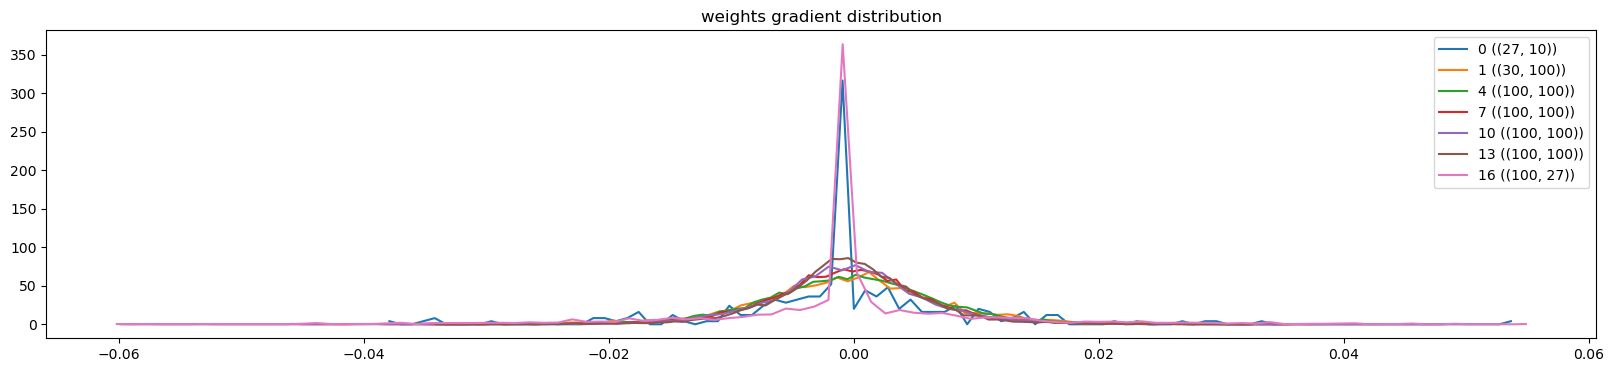

In [439]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:  #weights
        #grad:data ratio gives the scale of gradients compares to the scale of the actual value
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))

        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('weights gradient distribution')
# plt.savefig('Grad_0.5.png', dpi=300, bbox_inches='tight')

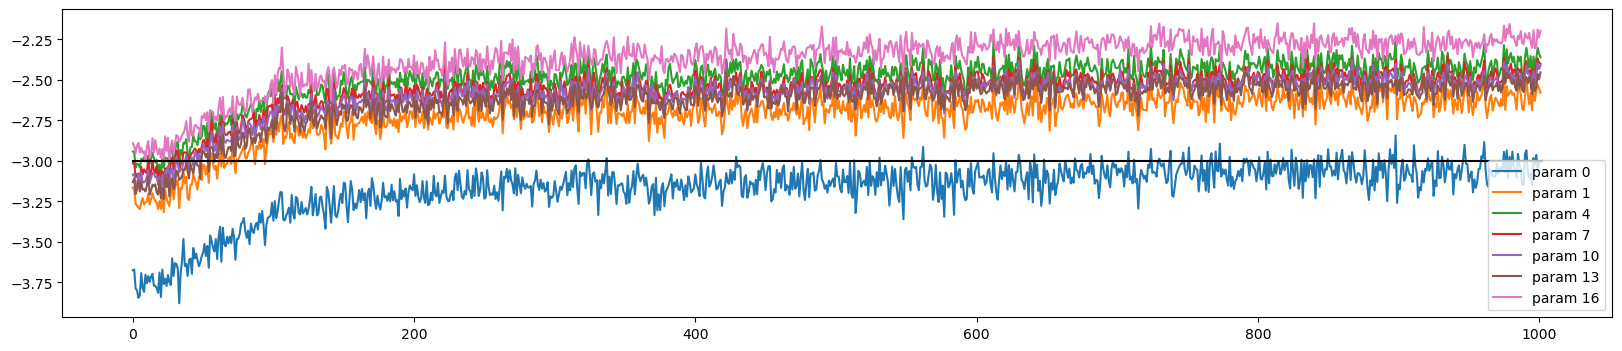

In [438]:

# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
  
    if p.ndim == 2:  #weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')  #these ratio should be ~1e-3, indicate on plot.
plt.legend(legends)
# plt.savefig('Update_Ratio0.1.png', dpi=300, bbox_inches='tight')

If below 1e-3, indicating training too slow